# Extract Structured Information from Case Texts
A sample of 10k files across different years and High Courts is used to create functions and processes to extract information. Helper functions are written in Pycharm and imported.

In [1]:
import os 
import re
import time
import csv
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import ik_parsing as ik
import data_extraction as de
import defs
from datetime import datetime
from collections import defaultdict
import itertools
import zipfile
import gzip
import json
import concurrent.futures

head, tail = os.path.split(os.getcwd())

In [2]:
import importlib
importlib.reload(ik)
importlib.reload(de)

<module 'data_extraction' from 'C:\\Users\\Nick\\Desktop\\Chicago\\DIME\\kanoon\\data_extraction.py'>

## 2. Extracting Structured Information from Case Text
Similar to what we did with the more structured Guwahati HC data, we now try to parse important information such as judge names, case types, names of litigants etc from the case text. It is incredibly hard due to different courts having different formats that also change with time.

Import a list of banks from a RBI linked website. This seems like an exhaustive list of ~160 banks in India.

### Without multiprocessing

In [215]:
courts = ['bombay', 'jharkhand']
df = pd.DataFrame()
# df_list = []

start = time.time()

for court in courts:
    list_of_dfs = []
    for year in range(2000, 2020):
        list_of_dfs.append(de.extract_data(court, year))
        print(f"{court} court done for year {year} at time --- {(time.time() - start)} seconds ---")

#         df = df.append(de.extract_data(court))
    temp_df = pd.concat(list_of_dfs)
    df = df.append(temp_df)

#     df_list.append(de.extract_data(court))

print(f"--- Total {(time.time() - start)} seconds ---")  
# takes ~1506 seconds for 500 limit break, takes 120s with 5 limit break and with court/year both iterated here.
print(df.shape)
df.head()

bombay court done for year 2000 at time --- 4.9758172035217285 seconds ---
bombay court done for year 2001 at time --- 5.445958614349365 seconds ---
bombay court done for year 2002 at time --- 6.237792015075684 seconds ---
bombay court done for year 2003 at time --- 6.9874045848846436 seconds ---
bombay court done for year 2004 at time --- 7.319717168807983 seconds ---
bombay court done for year 2005 at time --- 8.266783237457275 seconds ---
bombay court done for year 2006 at time --- 8.830883026123047 seconds ---
bombay court done for year 2007 at time --- 9.301111698150635 seconds ---
bombay court done for year 2008 at time --- 9.686726570129395 seconds ---
bombay court done for year 2009 at time --- 10.088056087493896 seconds ---
bombay court done for year 2010 at time --- 10.319886207580566 seconds ---
bombay court done for year 2011 at time --- 10.805779933929443 seconds ---
bombay court done for year 2012 at time --- 11.090831995010376 seconds ---
bombay court done for year 2013 

bombay court done for year 2006 at time --- 2.490288019180298 seconds ---
bombay court done for year 2007 at time --- 2.9134535789489746 seconds ---
bombay court done for year 2008 at time --- 3.2767767906188965 seconds ---
bombay court done for year 2009 at time --- 3.593202590942383 seconds ---
bombay court done for year 2010 at time --- 3.793717384338379 seconds ---
bombay court done for year 2011 at time --- 4.14783501625061 seconds ---
bombay court done for year 2012 at time --- 4.395179748535156 seconds ---
bombay court done for year 2013 at time --- 4.580114364624023 seconds ---
bombay court done for year 2014 at time --- 4.8183863162994385 seconds ---
bombay court done for year 2015 at time --- 5.197363376617432 seconds ---
bombay court done for year 2016 at time --- 5.551539897918701 seconds ---
bombay court done for year 2017 at time --- 6.215695142745972 seconds ---
bombay court done for year 2018 at time --- 6.52295994758606 seconds ---
bombay court done for year 2019 at ti

bombay court done for year 2018 at time --- 2.3600223064422607 seconds ---
bombay court done for year 2019 at time --- 2.5601155757904053 seconds ---
bombay court done for year 2017 at time --- 128.40993309020996 seconds ---
bombay court done for year 2018 at time --- 2.385251045227051 seconds ---
bombay court done for year 2019 at time --- 2.5701637268066406 seconds ---
bombay court done for year 2018 at time --- 131.09732747077942 seconds ---
bombay court done for year 2019 at time --- 2.0369558334350586 seconds ---
bombay court done for year 2019 at time --- 133.2502155303955 seconds ---


TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [5]:
courts = ['bombay', 'jharkhand']
df = pd.DataFrame()

start = time.time()

for court in courts:
    with zipfile.ZipFile(os.path.join(head, 'IK_data', court + '.zip'), 'r') as zip_folder:        
        list_of_dfs = []
        for year in range(2000, 2020):
            list_of_textfiles = [textfile for textfile in zip_folder.namelist() if
                                 textfile.startswith(f"{court}/{year}/") and textfile.endswith(".txt")]
            df_court_year = de.extract_to_df(zip_folder, list_of_textfiles)
            list_of_dfs.append(df_court_year)
            print(f"{court} court done for year {year} at time --- {(time.time() - start)} seconds ---")
        temp_df = pd.concat(list_of_dfs)
        df = df.append(temp_df)


print(f"--- Total {(time.time() - start)} seconds ---")  
# takes ~1506 seconds for 500 limit break, takes 120s with 5 limit break and with court/year both iterated here.
print(df.shape)
df

bombay court done for year 2000 at time --- 2.5707640647888184 seconds ---
bombay court done for year 2001 at time --- 3.3290650844573975 seconds ---
bombay court done for year 2002 at time --- 4.059908151626587 seconds ---
bombay court done for year 2003 at time --- 4.391266822814941 seconds ---
bombay court done for year 2004 at time --- 5.240583181381226 seconds ---
bombay court done for year 2005 at time --- 5.7807886600494385 seconds ---
bombay court done for year 2006 at time --- 6.170837163925171 seconds ---
bombay court done for year 2007 at time --- 6.533896446228027 seconds ---
bombay court done for year 2008 at time --- 6.849658489227295 seconds ---
bombay court done for year 2009 at time --- 7.050205230712891 seconds ---
bombay court done for year 2010 at time --- 7.416744709014893 seconds ---
bombay court done for year 2011 at time --- 7.673692941665649 seconds ---
bombay court done for year 2012 at time --- 7.856415510177612 seconds ---
bombay court done for year 2013 at 

,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,judge,banks,citations
0,bombay/2000/1001219.txt,NaN,Smt. Kamalabai Baburao Kabade vs Smt. Laxmibai...,2000-06-16,Bombay High Court,NaN,NaN,NaN,NaN,NaN,{A Khanwilkar},NaN,"{1331149, 1630779, 26690152, 1412634, 1001219,..."
1,bombay/2000/1004863.txt,NaN,Shri Vasant Devlal Bhavsar vs Bar Council Of M...,2000-07-19,Bombay High Court,2. one smt. s.v. vaishnav has lodged a complai...,NaN,NaN,NaN,NaN,"{A Shah, B Marlapalle}",NaN,"{1004863, 818009, 1439330, 1426050, 200474}"
2,bombay/2000/1007060.txt,NaN,Chandrakant Bhalchandra Garware vs Anil Prabha...,2000-02-09,Bombay High Court,the record and proceedings of the lower court ...,NaN,NaN,NaN,NaN,{D Deshpande},NaN,"{1331149, 1915814, 1314827, 1227984, 1262371, ..."
3,bombay/2000/1007895.txt,NaN,Trimbak S/O Waluba Sonwane vs The State Of Mah...,2000-02-29,Bombay High Court,2. crime no. 143/96 came to be registered agai...,NaN,NaN,NaN,NaN,"{B Marlapalle, D Zoting}",NaN,"{1543073, 1712542, 810491, 1007895, 291822, 11..."
4,bombay/2000/1011986.txt,NaN,Safruddin Abdul Majid Khan vs Mr. R.H. Mendonc...,2000-04-24,Bombay High Court,NaN,NaN,NaN,NaN,NaN,"{V Sahai, Kakade}",NaN,"{1011986, 313177, 16008, 1712542, 966422, 9151..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,jharkhand/2019/58878664.txt,NaN,Survinder Kaur vs The State Of Jharkhand,2019-11-14,Jharkhand High Court,apprehending her arrest in connection with orm...,,\n the state of jharkhand .... ......,NaN,NaN,{mr. justice anil kumar choudhary},NaN,"{1976294, 58878664, 94452, 1436241, 1897847, 1..."
1,jharkhand/2019/97365126.txt,NaN,Their Workmen Represented By ... vs Employer I...,2019-11-28,Jharkhand High Court,NaN,,\n employer in relation to t...,NaN,NaN,{the chief justice ...,NaN,{97365126}
2,jharkhand/2019/80192852.txt,NaN,Prashant Kumar Singh vs The State Of Jharkhand,2019-04-11,Jharkhand High Court,jainagar p.s. case no.136 of 2018 (g.r. no. 63...,,\n the state of jharkhand ...,NaN,NaN,{mr. justice anil kumar choudhary},NaN,"{1985627, 1897847, 80192852, 556166, 1823824, ..."
3,jharkhand/2019/182470721.txt,NaN,Diwakar Das vs The State Of Jharkhand,2019-09-24,Jharkhand High Court,"sarath p.s. case no. 199 of 2017, in which he ...",,\n the state of jharkhand ... ...,NaN,NaN,{mr. justice rongon mukhopadhyay},NaN,{182470721}


### With Multiprocessing

In [5]:
import importlib
importlib.reload(ik)
importlib.reload(de)
from multiprocessing import Pool
import defs


if __name__ == '__main__':
    start = time.time()
    df = pd.DataFrame()

    courts = ['bombay', 'jharkhand', 'chattisgarh']
    dfs = []
#     pool = Pool()
#     results = pool.imap(de.extract_data, courts)      
                
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(de.extract_data, courts)

    for result in results:
#         print(type(result))
#         dfs.append(pd.DataFrame(result))
        df = df.append(result)

# df = pd.concat(dfs)
print(f"--- {(time.time() - start)} seconds ---")  
# takes ~1506 seconds for 500 limit break; took ~4 hours or so for the MH, JH and CH
print(df.shape)
df.head()

--- 34062.94619631767 seconds ---
(624453, 13)


,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,judge,banks,citations
0,bombay/2000/1001219.txt,NaN,Smt. Kamalabai Baburao Kabade vs Smt. Laxmibai...,2000-06-16,Bombay High Court,NaN,NaN,NaN,NaN,NaN,{A Khanwilkar},NaN,"{1001219, 173132957, 1630779, 135316600, 26690..."
1,bombay/2000/1004863.txt,NaN,Shri Vasant Devlal Bhavsar vs Bar Council Of M...,2000-07-19,Bombay High Court,2. one smt. s.v. vaishnav has lodged a complai...,NaN,NaN,NaN,NaN,"{A Shah, B Marlapalle}",NaN,"{1426050, 200474, 1439330, 1004863, 818009}"
2,bombay/2000/1007060.txt,NaN,Chandrakant Bhalchandra Garware vs Anil Prabha...,2000-02-09,Bombay High Court,the record and proceedings of the lower court ...,NaN,NaN,NaN,NaN,{D Deshpande},NaN,"{1227984, 1326950, 43650, 1915814, 103053, 105..."
3,bombay/2000/1007895.txt,NaN,Trimbak S/O Waluba Sonwane vs The State Of Mah...,2000-02-29,Bombay High Court,2. crime no. 143/96 came to be registered agai...,NaN,NaN,NaN,NaN,"{B Marlapalle, D Zoting}",NaN,"{1039892, 1712542, 1543073, 11461, 1007895, 12..."
4,bombay/2000/1011986.txt,NaN,Safruddin Abdul Majid Khan vs Mr. R.H. Mendonc...,2000-04-24,Bombay High Court,NaN,NaN,NaN,NaN,NaN,"{V Sahai, Kakade}",NaN,"{752609, 1011986, 966422, 222396, 1636171, 313..."


In [ ]:
courts = ['bombay', 'jharkhand']
df = pd.DataFrame()
start = time.time()

if __name__ == '__main__':
    for court in courts:
        with zipfile.ZipFile(os.path.join(head, 'IK_data', court + '.zip'), 'r') as zip_folder:        
            list_of_dfs = []
            list_of_lists = []
            for year in range(2000, 2020):
                year_list = []
                for textfile in zip_folder.namelist():
                    if textfile.startswith(f"{court}/{year}/") and textfile.endswith(".txt"):
                        year_list.append(textfile)
                list_of_lists.append(year_list)
            
            with concurrent.futures.ProcessPoolExecutor() as executor:
                args = ((zip_folder, year_list) for year_list in list_of_lists)
                results = executor.map(lambda p: de.extract_to_df(*p), args)

        
print(f"--- Total {(time.time() - start)} seconds ---")  
# takes ~1506 seconds for 500 limit break, takes 120s with 5 limit break and with court/year both iterated here.
print(df.shape)
df.head()

here1
here2
here3


In [168]:
def citation_count_dict(df):
    citation_counts = defaultdict(int)

    for row in df.itertuples():
        if str(row.citations) != 'nan':
            for citation in row.citations:
                if citation != row.case_id:
                    citation_counts[citation] += 1
            row.citations.discard(row.case_id)
            
    return citation_counts

citation_counts = citation_count_dict(df2)

AttributeError: 'Pandas' object has no attribute 'case_id'

In [53]:
df.reset_index(drop=True, inplace=True)
df['case_id'] = df['file'].apply(lambda x: x[x.rfind('/')+1:-4]) 

df['times_cited'] = df['case_id'].apply(lambda x: citation_counts.get(x, 0))

df['bench_size'] = df.loc[:,'judge'].dropna().apply(len)


        
df['num_citations'] = df.loc[:,'citations'].dropna().apply(len)

df['chief_justice'] = df.loc[:,'judge'].dropna().apply(lambda x: (any('chief' in item for item in x)))

keywords_state = ['state', 'government', 'commissioner', 'national', 'india', 'indian', 'public', 'magistrate',
                  'collector', 'department', 'district']
df['state'] = df.loc[:,'title'].dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_state)))

keywords_business = ['pvt', 'private', 'limited', 'ltd', 'company', 'co.', 'llp', 'llc']
df['business'] = (df.loc[:,'petitioner']+df.loc[:,'respondent']).dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_business)))

keywords_male = ['shri', 'mr.', 'master']

df.replace('\n', ' ', regex = True, inplace = True)
df.head()

,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,judge,banks,citations,bench_size,num_citations,chief_justice,state,business,case_id,times_cited
0,bombay/2000/1001219.txt,NaN,Smt. Kamalabai Baburao Kabade vs Smt. Laxmibai...,2000-06-16,Bombay High Court,NaN,NaN,NaN,NaN,NaN,{A Khanwilkar},NaN,"{1630779, 1331149, 1108515, 135316600, 1412634...",1.0,7.0,False,False,NaN,1001219,6
1,bombay/2000/1004863.txt,NaN,Shri Vasant Devlal Bhavsar vs Bar Council Of M...,2000-07-19,Bombay High Court,2. one smt. s.v. vaishnav has lodged a complai...,NaN,NaN,NaN,NaN,"{A Shah, B Marlapalle}",NaN,"{818009, 1439330, 1426050, 200474}",1.0,4.0,False,False,NaN,1004863,0
2,bombay/2000/1007060.txt,NaN,Chandrakant Bhalchandra Garware vs Anil Prabha...,2000-02-09,Bombay High Court,the record and proceedings of the lower court ...,NaN,NaN,NaN,NaN,{D Deshpande},NaN,"{1953529, 487818, 1038208, 1326950, 1227984, 1...",1.0,16.0,False,False,NaN,1007060,0
3,bombay/2000/1007895.txt,NaN,Trimbak S/O Waluba Sonwane vs The State Of Mah...,2000-02-29,Bombay High Court,2. crime no. 143/96 came to be registered agai...,NaN,NaN,NaN,NaN,"{B Marlapalle, D Zoting}",NaN,"{142278, 11461, 1228265, 1290514, 1712542, 119...",1.0,12.0,False,True,NaN,1007895,0
4,bombay/2000/1011986.txt,NaN,Safruddin Abdul Majid Khan vs Mr. R.H. Mendonc...,2000-04-24,Bombay High Court,NaN,NaN,NaN,NaN,NaN,"{V Sahai, Kakade}",NaN,"{915147, 1712542, 752609, 578299, 16008, 21227...",1.0,15.0,False,True,NaN,1011986,3


In [178]:
df.to_pickle('df_7courts.pkl')

In [162]:
df = pd.read_pickle('df_mhjhch.pkl')

In [177]:
# df2.reset_index(drop=True, inplace=True)

# df2['bench_size'] = df2.loc[:,'judge'].dropna().apply(len)


        
# df2['num_citations'] = df2.loc[:,'citations'].dropna().apply(len)

# df2['chief_justice'] = df2.loc[:,'judge'].dropna().apply(lambda x: (any('chief' in item for item in x)))

# keywords_state = ['state', 'government', 'commissioner', 'national', 'india', 'indian', 'public', 'magistrate',
#                   'collector', 'department', 'district']
# df2['state'] = df2.loc[:,'title'].dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_state)))

# keywords_business = ['pvt', 'private', 'limited', 'ltd', 'company', 'co.', 'llp', 'llc']
# df2['business'] = (df2.loc[:,'petitioner']+df2.loc[:,'respondent']).dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_business)))

df.court.value_counts()

Jharkhand High Court          338969
Allahabad High Court          228124
Bombay High Court             221571
Gauhati High Court             64640
Chattisgarh High Court         59361
Jammu & Kashmir High Court     36713
Andhra High Court              14263
Name: court, dtype: int64

The number of missing values. Try and get this to around 85-90% and above to proceed. Judges we are extracting at a reasonable accuracy. Next step is to optimize advocates but that is a lot more difficult. Will have to try NER or other approaches. 

In [7]:
df.isna().sum()

file                        0
cnr_num                624452
title                    4552
date                     4552
court                    4552
case_number            491698
petitioner             180917
respondent             180917
petitioner_advocate    600972
respondent_advocate    622160
judge                   20879
banks                  608455
citations                4540
bench_size              20879
num_citations            4540
chief_justice           20879
state                    4552
business               180917
dtype: int64

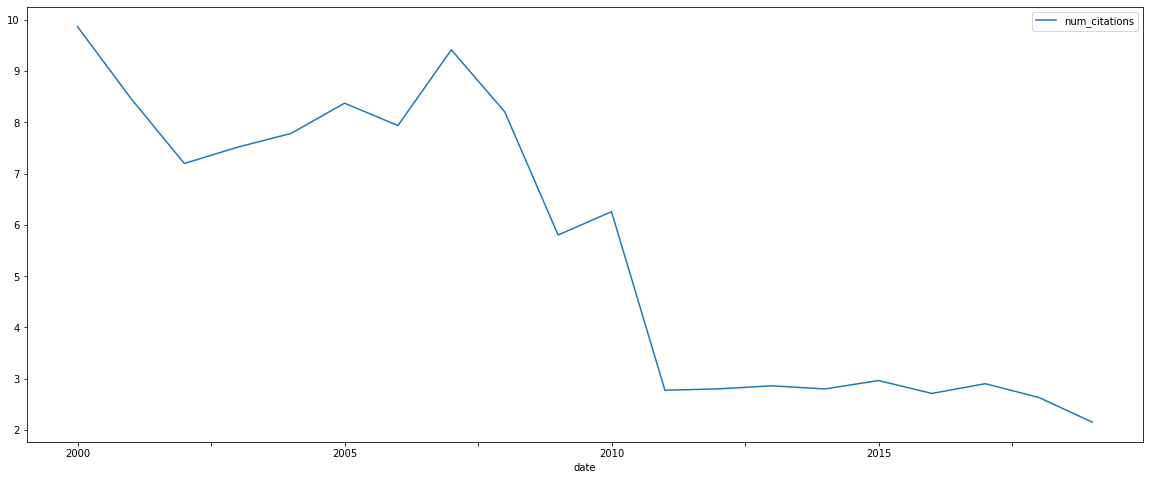

In [6]:
mean_citations_monthly = pd.DataFrame(df.groupby(df[df.date>"2000-01-01"].date.dt.strftime('%Y'))['num_citations'].mean())
mean_citations_monthly.plot(figsize=(20,8))

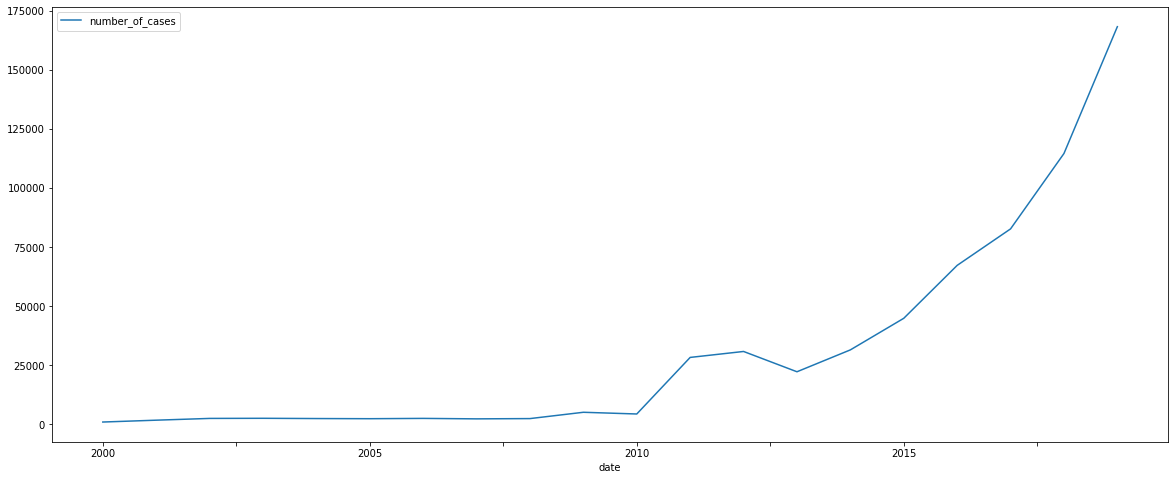

In [7]:
cases_by_time = pd.DataFrame(df.groupby(df[df.date>"2000-01-01"].date.dt.strftime('%Y')).size())
cases_by_time.columns = ['number_of_cases']
cases_by_time.plot(figsize=(20,8))

Text(0, 0.5, 'Mean Number of Citations per Case by Year')

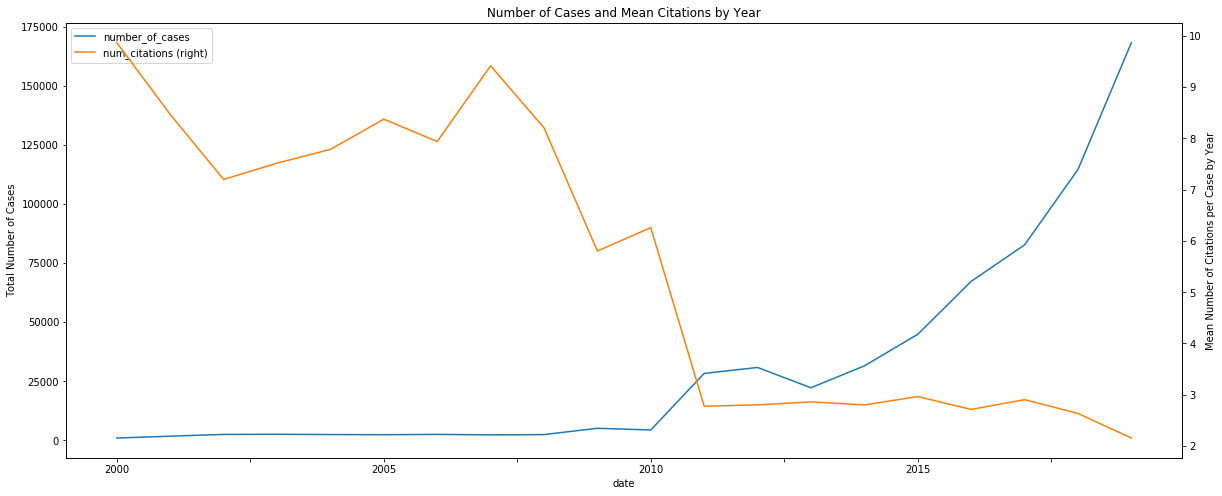

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cases_by_time.plot(figsize=(20,8), ax=ax)
ax.set_ylabel("Total Number of Cases")

mean_citations_monthly.plot(figsize=(20,8), secondary_y=True, ax=ax, title='Number of Cases and Mean Citations by Year')
plt.ylabel("Mean Number of Citations per Case by Year")

Text(0, 0.5, 'Mean number of citations per case by Year')

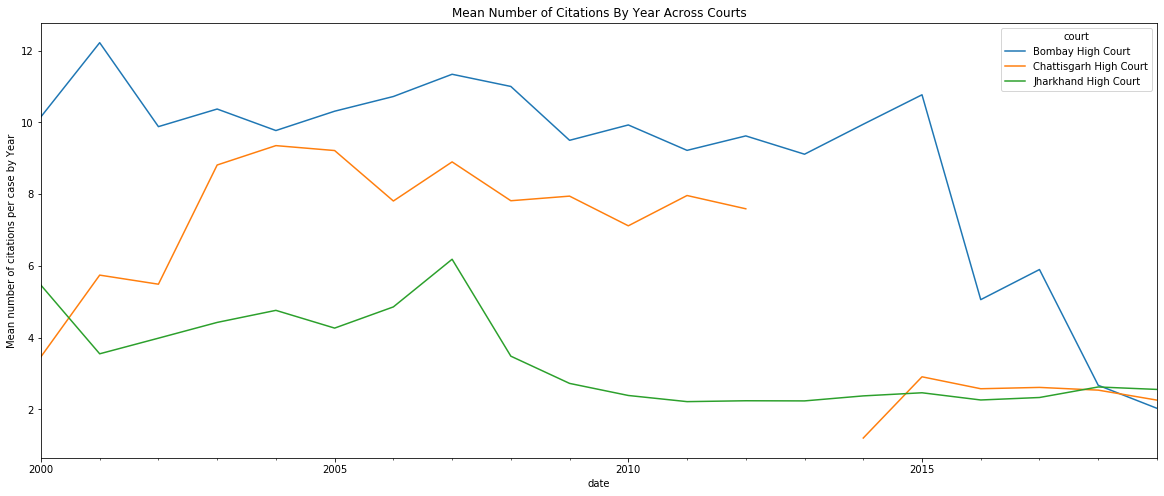

In [41]:
citations_by_court_year = df
citations_by_court_year.index = pd.to_datetime(citations_by_court_year.date.dt.strftime('%Y'), format='%Y')
plot2 = citations_by_court_year.pivot_table(index = citations_by_court_year.index,columns='court',values='num_citations',aggfunc='mean').plot(figsize=(20,8), title="Mean Number of Citations By Year Across Courts")
plot2.set_ylabel("Mean number of citations per case by Year")

Text(0, 0.5, 'Total Number of Cases')

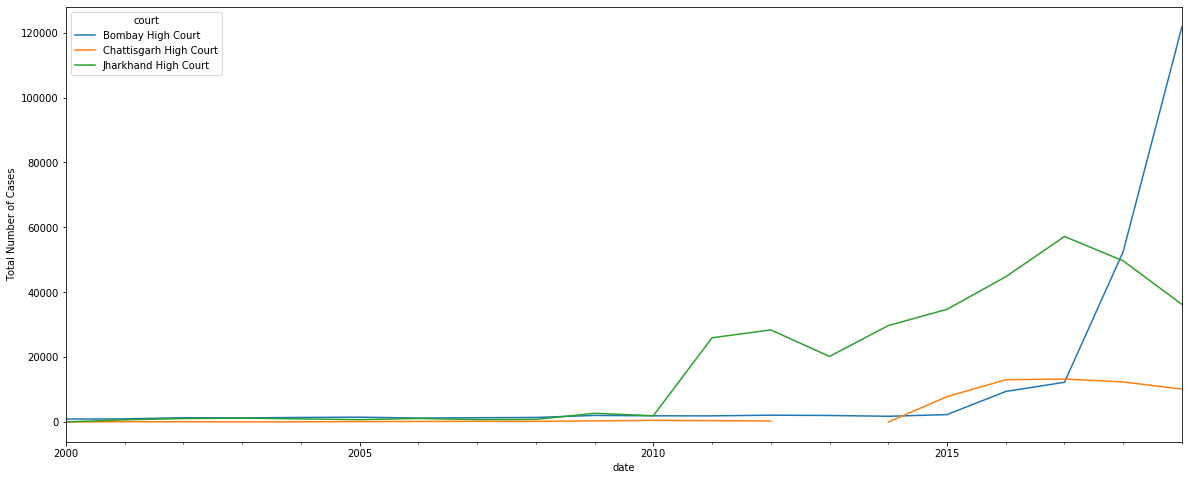

In [43]:
cases_by_court_year = df
cases_by_court_year.index = pd.to_datetime(cases_by_court_year.date.dt.strftime('%Y'), format='%Y')
plot3 = cases_by_court_year.pivot_table(index = cases_by_court_year.index,columns='court',values='num_citations',aggfunc='count').plot(figsize=(20,8))
plot3.set_ylabel("Total Number of Cases")

In [44]:
df.groupby(df.date.dt.strftime('%Y')).size()

date
2000       978
2001      1761
2002      2507
2003      2558
2004      2451
2005      2386
2006      2517
2007      2321
2008      2437
2009      5106
2010      4381
2011     28314
2012     30830
2013     22247
2014     31501
2015     44862
2016     67248
2017     82690
2018    114575
2019    168231
dtype: int64

In [47]:
df.groupby('court').size()

court
Bombay High Court         221571
Chattisgarh High Court     59361
Jharkhand High Court      338969
dtype: int64

In [16]:
from textdistance import smith_waterman, needleman_wunsch, jaro_winkler, jaccard, levenshtein

judges_dict = defaultdict(int)
for judge_set in df['judge']:
    if str(judge_set)!='nan':
        for judge in judge_set:
            judges_dict[judge] += 1
        

In [17]:
print(len(judges_dict))        

for judge_pair in itertools.combinations(judges_dict, 2):
    score = jaccard.normalized_similarity(judge_pair[0], judge_pair[1])
    if score>0.95:
        carryover = judges_dict.pop(judge_pair[1], 0)
        judges_dict[judge_pair[0]] += carryover

print(len(judges_dict))

15415
13784


15415 entries trimmed to 13784 judges after merging similar key values above.

## Forward Citations
I think cases after 2009 were uploaded as they were put up online by the courts as Sushant I believe said he had a daily crawler. In that case we do not have a pre period to compare the pre vs post putting the case up on IK. What we could do instead is to check the pre vs post for cases before 2009 when IK did not exist. For these older cases we can check their average citations before IK and then after to see if there exists any jump. However, the problem here is the very small number of cases we have for years before 2009. 

In [64]:
pre2009cases = df[df.date.dt.year<2009].case_id.to_list()

for case in pre2009cases:
    for row in df.itertuples():
        print(row.date.year)
        break

2000


In [73]:
sum(citation_counts.values())

1137181

## Citation Diversity

In [105]:
np.array(list(citation_count_dict(df.loc[df.date.dt.year==2000,:]).values()))/10 

array([0.1, 9.5, 0.1, ..., 0.1, 0.1, 0.1])

In [98]:
a = [1,2,3]
b = np.array(a)
print(b)
(b/1)*b

[1 2 3]


array([1., 4., 9.])

In [154]:

def citation_diversity(df):
    hhi_indices = []
    for year in range(2000, 2020):
        citation_counts_year = list(citation_count_dict(df.loc[df.date.dt.year==year, :]).values())
#         print('sum', citation_counts_year[:10], sum(citation_counts_year))
        array_p_i = np.array(citation_counts_year)/sum(citation_counts_year)
        hhi = array_p_i * array_p_i
        hhi_indices.append(sum(hhi))
    return pd.DataFrame({'year': list(range(2000,2020)), 'citation_diversity_index': hhi_indices})

citation_diversity_bombay = citation_diversity(df.loc[df.court=='Bombay High Court', :]) 
citation_diversity_bombay.index = (citation_diversity_bombay.year)
citation_diversity_bombay

,year,citation_diversity_index
year,,
2000,2000,0.001151
2001,2001,0.000921
2002,2002,0.001033
2003,2003,0.000786
2004,2004,0.000841
2005,2005,0.000831
2006,2006,0.000760
2007,2007,0.000768
2008,2008,0.000994


In [148]:
citation_diversity_bombay.plot(x='year', y='citation_diversity_index', figsize=(20,18))

NameError: name 'citation_diversity_bombay' is not defined

In [137]:
a = [5,3,7]
a.sort()
a[1]
sum(a)

15

In [136]:
sum(citation_counts.values())

1137181